### Àlex Correa Orri 1564967
### Júlia Pumares Benaiges 1566252

#### Dataset explicat: https://rpubs.com/rhuebner/hrd_cb_v14
#### Descàrrega dataset: https://www.kaggle.com/rhuebner/human-resources-data-set

In [1]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  (), please run `%reset?` for details


### MÒDULS I LLIBRERIES

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
import os
import seaborn as sns
from scipy.stats import shapiro, spearmanr
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import ipympl
%matplotlib widget

### DIRECTORI DE TREBALL

In [2]:
os.getcwd()
path = 'C:/Users/alexc/OneDrive/Escritorio/UNI/3er/Aprenentatge Computacional/pràctiques/PRÀCTICA 1'
os.chdir(path)
os.getcwd()
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### LECTURA DE DADES

In [3]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('HRDataset_v14_.csv')

### MODIFICACIÓ DEL DATASET

In [4]:
dataset.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'Salary', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30',
       'Absences'],
      dtype='object')

#### ELiminem atributs

In [5]:
dataset = dataset.drop(['Employee_Name','EmpID', 'MarriedID', 'DeptID', 'Zip', 'ManagerID', 'LastPerformanceReview_Date', 'MaritalStatusID', 'EmpStatusID', 'PositionID', 'Sex', 'PerformanceScore'], axis=1) 
dataset.HispanicLatino = dataset.HispanicLatino.replace({'No': 0, 'no': 0, 'Yes': 1, 'yes': 1})

#### Modifiquem atributs de dates a valors numèrics en dies

In [6]:
def date2date(list_dates):
    list_dates_def = []
    for date in list_dates:
        if (len(date.split('/')[2]) == 2):
            s = date.split('/')
            s[2] = '19'+s[2]
            date = s[0]+'/'+s[1]+'/'+s[2]
        list_dates_def.append(date)
    return list_dates_def

In [7]:
today = '1/1/2020'
#passem les dates (date of hire i date of termination) a date_time
dataset['DateofHire'] = pd.to_datetime(dataset['DateofHire'], format='%m/%d/%Y')
dataset['DateofTermination'].fillna(today, inplace = True) #posem 2020 com a data actual o de referència
dataset['DateofTermination'] = pd.to_datetime(dataset['DateofTermination'], format='%m/%d/%Y')
dataset['WorkedDays'] = (dataset['DateofTermination'] - dataset['DateofHire']).astype('timedelta64[D]')
dataset = dataset.drop(['DateofTermination', 'DateofHire'], axis=1)
#passem DOB a datetime i ho transformem a edat (per tenir una valor numèric)
dataset['DOB'] = date2date(dataset['DOB'])
dataset['DOB'] = pd.to_datetime(dataset['DOB'], format='%m/%d/%Y')
dataset['Age'] = (pd.to_datetime(today, format='%m/%d/%Y') - dataset['DOB']).astype('timedelta64[D]')
dataset = dataset.drop(['DOB'], axis=1)

#### Passem les columnes categòriques a binàries

In [8]:
columns = ['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc']

for col in columns:
    if dataset[col].dtype == 'object':
        #print(col)
        dataset = pd.concat([dataset, pd.get_dummies(dataset[col], prefix=col)], axis=1)


In [9]:
dataset = dataset.drop(['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc'], axis=1) 

In [10]:
dataset = dataset.rename(columns={'Department_Production       ': 'Department_Production'})

#### //Treiem els 'outliers' del salari

In [11]:
#list(dataset.columns)

In [12]:
dataset = dataset[dataset['Salary'] < 125000]
#hem provat diferents valors i aquest va millor (per l'error de les regressions)

In [13]:
dataset = dataset[dataset['WorkedDays'] < 3800]

In [14]:
dataset = dataset[dataset['WorkedDays'] > 1000]

In [15]:
dataset = dataset[dataset['EngagementSurvey'] > 2.6]

(950.0, 3637.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
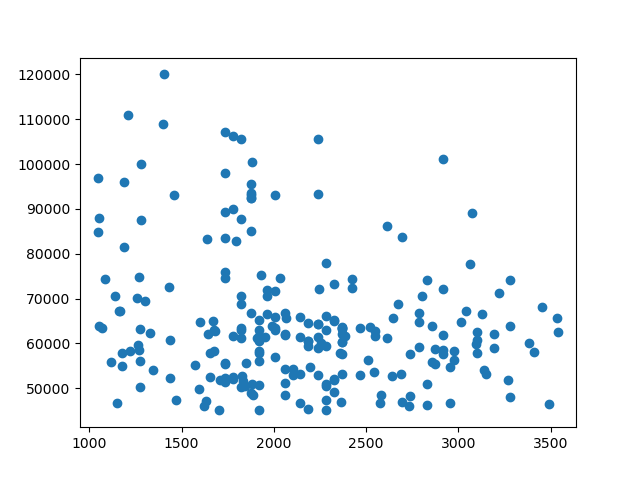

In [16]:
plt.figure()
printed_data = 'WorkedDays'
plt.scatter(dataset[printed_data],dataset['Salary'])
plt.xlim(min(dataset[printed_data])-100, max(dataset[printed_data])+100)

In [17]:
for d in dataset:
    if ((max(dataset[d])==1 or max(dataset[d])==0) and (min(dataset[d])==0 or min(dataset[d])==1) and (d != 'GenderID')):
        dataset = dataset.drop([d], axis=1)

In [18]:
dataset.shape

(234, 10)

### INFORMACIÓ DEL DATASET

In [19]:
dataset.columns

Index(['GenderID', 'PerfScoreID', 'Salary', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'WorkedDays', 'Age'],
      dtype='object')

In [20]:
data = dataset.values

x = data[:, :dataset.shape[0]]
y = data[:, 2]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (234, 10)
Dimensionalitat de les entrades X (234, 10)
Dimensionalitat de l'atribut Y (234,)


In [21]:
#print("Print dataset:")
#print(dataset)

In [22]:
#print(dataset.describe())
#list(dataset.columns)

### ANALITZANT LES DADES

#### Buscant atributs amb distribució Gaussiana

In [23]:
#provem amb el salari
ax = sns.distplot(x[:,2])

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [24]:
shapiro(x[:,2])

ShapiroResult(statistic=0.8829081058502197, pvalue=1.807173985110544e-12)

In [25]:
#Normallity tests
#HISTOGRAMA
c = 0
for col in dataset.columns:
    stat, p = shapiro(x[:,c])
    if p > 0.00000000000000005:
        print(c)
        print(p)
        print(dataset.columns[c])
        print('------------------------')
    c += 1
#v = 2
#ax = sns.distplot(x[:,v])
#no hi ha cap atribut amb distribució normal

2
1.807173985110544e-12
Salary
------------------------
3
2.3114647973443425e-09
EngagementSurvey
------------------------
4
2.355234190388653e-15
EmpSatisfaction
------------------------
7
3.231565770533962e-08
Absences
------------------------
8
0.0004966543638147414
WorkedDays
------------------------
9
2.603979698534431e-09
Age
------------------------


In [26]:
dataset.columns

Index(['GenderID', 'PerfScoreID', 'Salary', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'WorkedDays', 'Age'],
      dtype='object')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
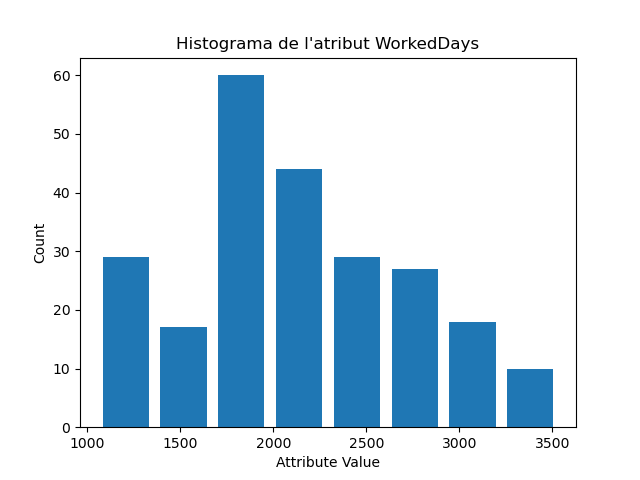

In [27]:
atr17 = 8
plt.figure()
plt.title("Histograma de l'atribut "+dataset.columns[atr17])
plt.xlabel("Attribute Value")
plt.ylabel("Count")
hist = plt.hist(x[:,atr17], bins=8, range=[np.min(x[:,atr17]), np.max(x[:,atr17])], histtype="bar", rwidth=0.8)

#### Visualització de les relacions entre atributs

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
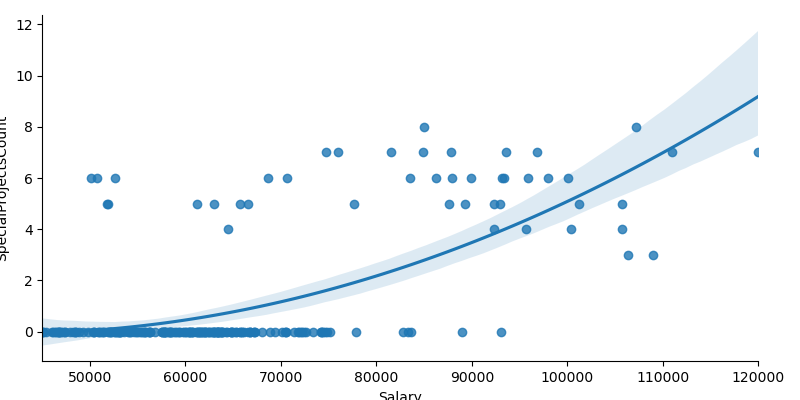

In [28]:
# Visualització de la relacó entre el salari i el recompte de projectes (SpecialProjectsCount)
sns.lmplot('Salary', 'SpecialProjectsCount', dataset, order = 2,size = 4, aspect = 2)

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
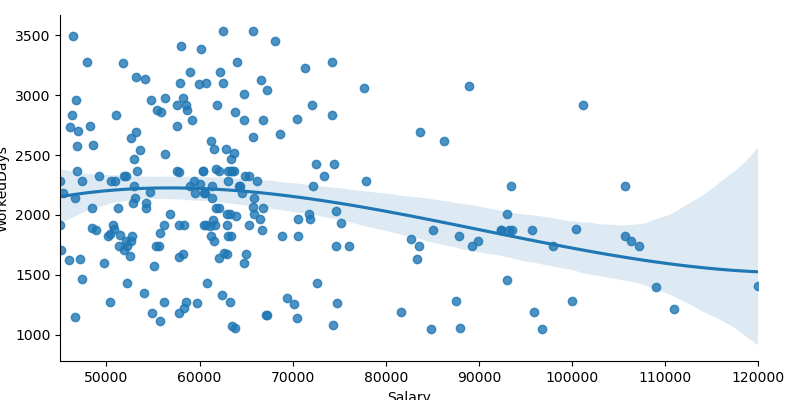

In [29]:
sns.lmplot('Salary', 'WorkedDays', dataset, order = 3,size = 4, aspect = 2)

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
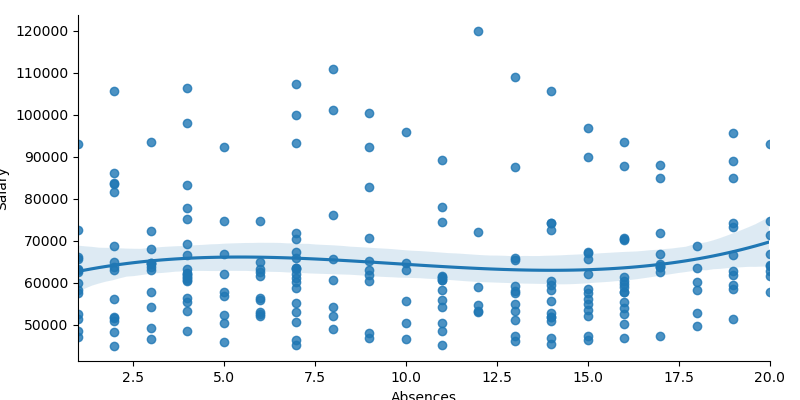

In [30]:
sns.lmplot('Absences', 'Salary', dataset, order = 3,size = 4, aspect = 2)

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
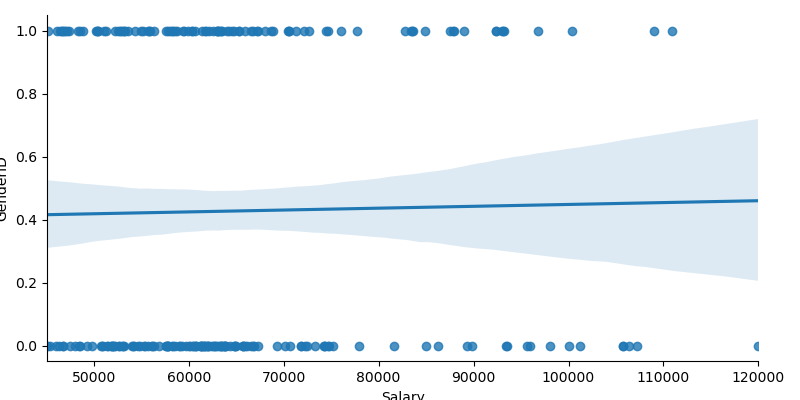

In [31]:
sns.lmplot('Salary', 'GenderID', dataset, order = 1,size = 4, aspect = 2)

#### Busquem correlació entre els atributs

In [32]:
#correlació de Spearman (per a distribucions no gaussianes)
i=0
cols_corr = []
for col in dataset.columns:
    s, p = spearmanr(x[:,i], y)
    #if (abs(s) > 0.00000000000001 and p < 0.05):
        #and p < 0.05):
    if True:
        print('Atribut '+ str(i) + ' ' + col)
        cols_corr.append(col)
        print(spearmanr(x[:,i], y))
        print("-----------------------------------------------------------------------------------")
    i = i + 1
#p-value < 0.05 la correlació és significant

Atribut 0 GenderID
SpearmanrResult(correlation=0.016369541120544954, pvalue=0.8032976754305855)
-----------------------------------------------------------------------------------
Atribut 1 PerfScoreID
SpearmanrResult(correlation=0.05943515384289806, pvalue=0.3654046015775446)
-----------------------------------------------------------------------------------
Atribut 2 Salary
SpearmanrResult(correlation=1.0, pvalue=0.0)
-----------------------------------------------------------------------------------
Atribut 3 EngagementSurvey
SpearmanrResult(correlation=-0.04916642226496004, pvalue=0.45414238818473784)
-----------------------------------------------------------------------------------
Atribut 4 EmpSatisfaction
SpearmanrResult(correlation=0.022303598279226046, pvalue=0.7343124560673149)
-----------------------------------------------------------------------------------
Atribut 5 SpecialProjectsCount
SpearmanrResult(correlation=0.49881349735630093, pvalue=3.999473828559406e-16)
------

In [33]:
dataset1 = dataset[cols_corr]
data = dataset1.values
i = 0
for d in dataset1:
    if (d=='Salary'):
        break
    i+=1
    
x = data[:, :dataset1.shape[0]]
y = data[:, dataset1.shape[1]-1]

In [34]:
dataset1.shape

(234, 10)

In [35]:
dataset1.corr()['Salary']

GenderID                0.018
PerfScoreID             0.080
Salary                  1.000
EngagementSurvey       -0.022
EmpSatisfaction         0.041
SpecialProjectsCount    0.644
DaysLateLast30         -0.101
Absences                0.014
WorkedDays             -0.222
Age                    -0.025
Name: Salary, dtype: float64

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
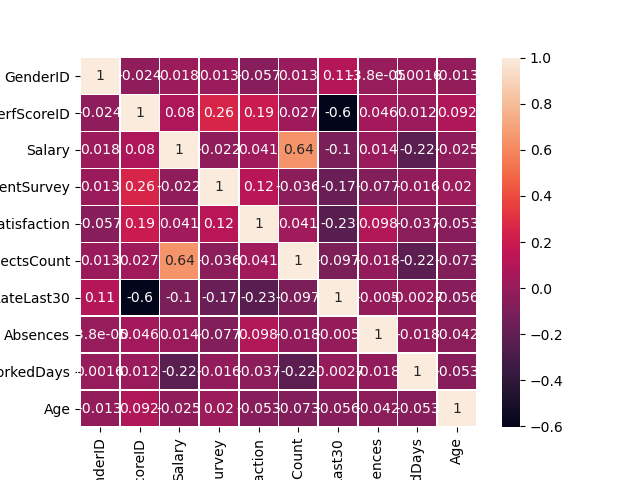

In [36]:
# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset1.corr()

plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
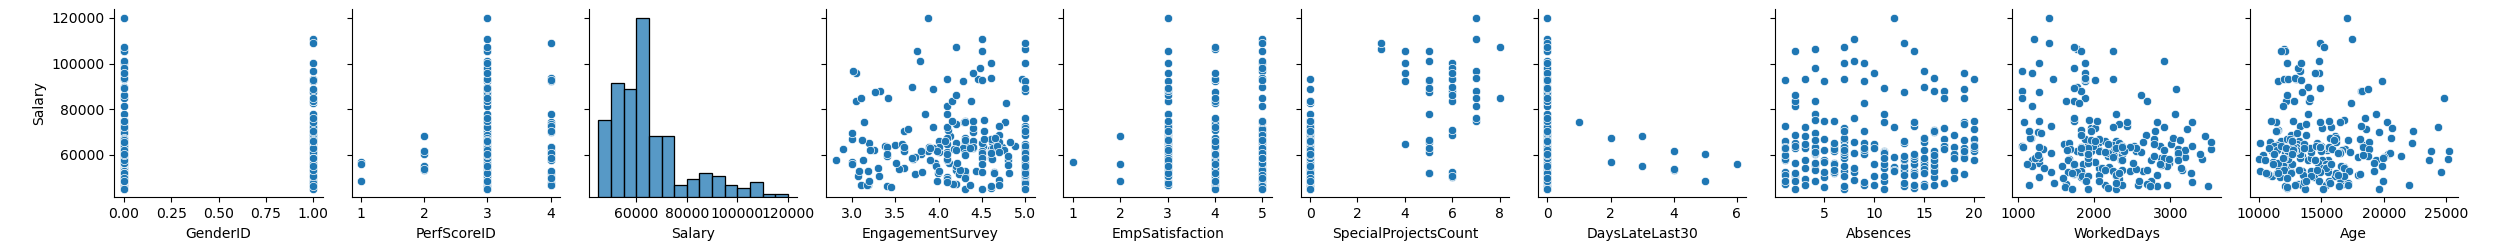

In [37]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset1, y_vars = 'Salary')

### Histogrames

#### Quantitat de persones per rangs de salaris a continuació. Es veu com poques persones cobren molt i la majoria es troba en sous més baixos

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
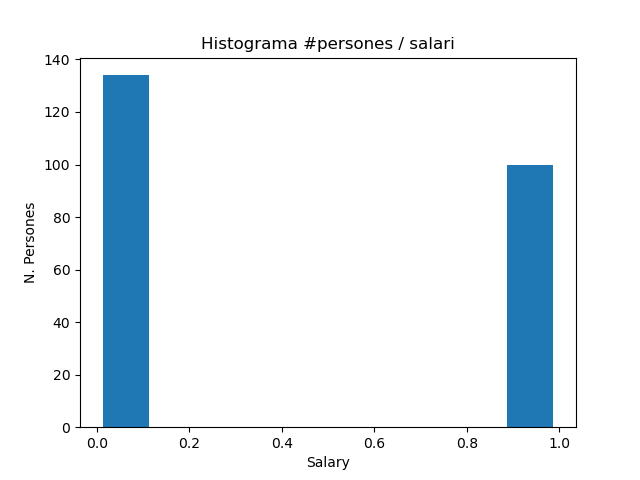

In [38]:
plt.figure()
plt.title("Histograma #persones / salari")
plt.xlabel("Salary")
plt.ylabel("N. Persones")
v = 0
hist = plt.hist(x[:,v], bins=8, range=[np.min(x[:,v]), np.max(x[:,v])], histtype="bar", rwidth=0.8)

### PRIMERES REGRESSIONS

#### FUNCIONS PER LA REGRESSIÓ

In [39]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr
def standarize(x_train):#normalitzar dades
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t
def split_data(x_standar, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

#### Regressió amb l'atribut at1

In [40]:
dataset1.columns

Index(['GenderID', 'PerfScoreID', 'Salary', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'WorkedDays', 'Age'],
      dtype='object')

l'atribut: 5 SpecialProjectsCount
Mean squeared error:  10239924.922829058
R2 score:  0.005280457151395246


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
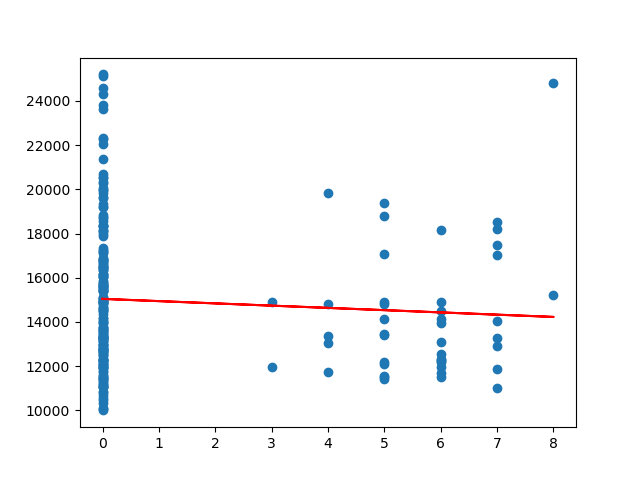

In [41]:
#regressió sense normalitzar
at1 = 5
print("l'atribut: "+ str(at1) +' '+ dataset1.columns[at1])
atribut1 = x[:,at1].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,at1], y)
plt.plot(atribut1[:,0], predicted, 'r')
# Mostrem l'error (MSE i R2)
MSE = mse(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

l'atribut: 5 SpecialProjectsCount
Mean squeared error:  0.585459795028097
R2 score:  0.414540204971903


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
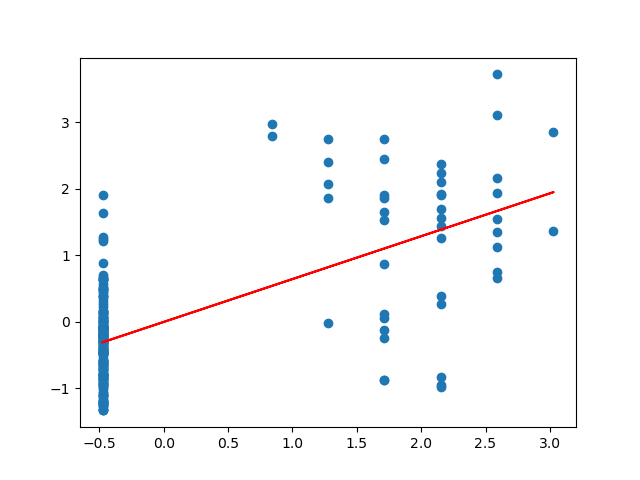

In [42]:
#regressió amb dades normalitzades
at1 = 5
print("l'atribut: "+ str(at1) +' '+ dataset1.columns[at1])
data = dataset1.values
x = data[:, :dataset.shape[0]]
x = standarize(x)
i = 0
for d in dataset1:
    if (d=='Salary'):
        break
    i+=1
y = x[:,i]
atribut1 = x[:,at1].reshape(x.shape[0], 1)

regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,at1], y)
plt.plot(atribut1[:,0], predicted, 'r')
# Mostrem l'error (MSE i R2)
MSE = mse(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

#### Regressió amb tots els atributs (que tenen una correlació, dataset1)

In [43]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
data = dataset1.values
x = data[:, :dataset.shape[0]]
x = standarize(x)
i = 0
for d in dataset1:
    if (d=='Salary'):
        break
    i+=1
y = x[:,i]
# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)
errors = []
for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    errors.append(error)
    print(dataset1.columns[i])
    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))
    print("------------------------------------")

#errors[0]=10
print(errors)
#print(errors.index(min(errors)))

GenderID
Error en atribut 0: 1.258878
R2 score en atribut 0: -0.021127
------------------------------------
PerfScoreID
Error en atribut 1: 1.239264
R2 score en atribut 1: -0.005217
------------------------------------
Salary
Error en atribut 2: 0.000000
R2 score en atribut 2: 1.000000
------------------------------------
EngagementSurvey
Error en atribut 3: 1.253363
R2 score en atribut 3: -0.016654
------------------------------------
EmpSatisfaction
Error en atribut 4: 1.249673
R2 score en atribut 4: -0.013660
------------------------------------
SpecialProjectsCount
Error en atribut 5: 0.558862
R2 score en atribut 5: 0.546684
------------------------------------
DaysLateLast30
Error en atribut 6: 1.231114
R2 score en atribut 6: 0.001393
------------------------------------
Absences
Error en atribut 7: 1.276347
R2 score en atribut 7: -0.035297
------------------------------------
WorkedDays
Error en atribut 8: 1.164338
R2 score en atribut 8: 0.055558
---------------------------------

In [44]:
print(sorted(errors))

[3.1496001554311894e-32, 0.5588623349517188, 1.1643382242049944, 1.2311141662892966, 1.2392638558725368, 1.2496728507578034, 1.253363468434867, 1.2588780530501744, 1.2598572617534223, 1.276347425389622]


### EL DESCENS DEL GRADIENT

In [77]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

    def predict(self, x):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x[i]
        hy = []
        for xx in (x):
            hy.append(self.w0 + self.w1*xx)
        return hy
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        d_w0 = 0
        d_w1 = 0
        for i in range(m):
            d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x[i]
        
        l = 2.0
        d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        
        #Calculem les noves w0 i w1
        self.w1 = self.w1 - self.alpha * d_w1
        self.w0 = self.w0 - self.alpha * d_w0
    
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x)
            y_pred = self.predict(x)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 2.0
            J = (J + l*(self.w0**2 + self.w1**2))/(2*m)
            i += 1
            print(J)
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x[i]")
        return J, self.w0, self.w1

In [78]:
dataset1.columns

Index(['GenderID', 'PerfScoreID', 'Salary', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'WorkedDays', 'Age'],
      dtype='object')

In [79]:
at = 5
obj_reg = Regressor(0.5, 0.5, 0.01)
obj_reg.predict(x[:,0])
max_iter = 1000
epsilon = 0.15
J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at], y)

0.4296351265752844
0.42575614720174854
0.42314067248604637
0.4205799054073229
0.41807022722678105
0.41561061498785645
0.4132000714853701
0.4108376193720522
0.4085223007519816
0.40625317679359363
0.40402932735039976
0.40184985058926076
0.3997138626260463
0.39762049716854825
0.39556890516649046
0.3935582544685041
0.39158772948592635
0.38965653086328167
0.38776387515532384
0.3859089945104975
0.38409113636069686
0.3823095631171973
0.38056355187263263
0.37885239410890115
0.37717539541088374
0.3755318751858543
0.37392116638846945
0.372342615251235
0.37079558102032695
0.3692794356966719
0.3677935637821746
0.3663373620309964
0.3649102392057785
0.3635116158387157
0.3621409239973834
0.3607976070552199
0.3594811194665776
0.35819092654624773
0.356926504253367
0.35568733897963095
0.3544729273417109
0.35328277597780666
0.35211640134824385
0.35097332954003696
0.3498530960753415
0.34875524572371563
0.3476793323181174
0.34662491857456096
0.3455915759153601
0.34457888429588956
0.34358643203479045
0.3426

0.2951772528660813
0.29517726216721857
0.29517727138551697
0.29517728052161174
0.2951772895761343
0.2951772985497151
0.2951773074429807
0.29517731625655486
0.29517732499106
0.29517733364711374
0.295177342225333
0.29517735072632983
0.29517735915071425
0.2951773674990937
0.295177375772072
0.29517738397025023
0.2951773920942262
0.2951774001445951
0.295177408121949
0.2951774160268758
0.29517742385996154
0.29517743162178844
0.2951774393129361
0.29517744693397974
0.2951774544854927
0.29517746196804434
0.2951774693822006
0.295177476728525
0.2951774840075769
0.2951774912199126
0.29517749836608503
0.29517750544664434
0.29517751246213625
0.2951775194131044
0.2951775263000882
0.2951775331236243
0.2951775398842452
0.2951775465824804
0.2951775532188567
0.2951775597938962
0.2951775663081192
0.2951775727620409
0.2951775791561742
0.29517758549102857
0.29517759176711006
0.2951775979849205
0.2951776041449597
0.2951776102477225
0.2951776162937026
0.2951776222833879
0.29517762821726423
0.2951776340958137


SpecialProjectsCount


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
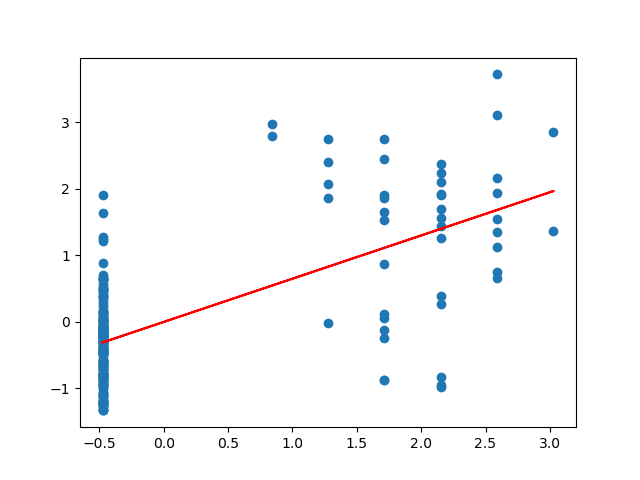

In [80]:
print(dataset1.columns[at])
plt.figure()
ax = plt.scatter(x[:,at], y)
plt.plot(x[:,at], w0+w1*x[:,at], 'r')

In [84]:
class Regressor2(object):
    def __init__(self, w0, w1, w2, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.alpha = alpha

    def predict(self, x):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x[i] + w2*x[i]^2
        hy = []
        for xx in (x):
            hy.append(self.w0 + self.w1*xx + self.w2*xx*xx)
        return hy
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        d_w0 = 0
        d_w1 = 0
        d_w2 = 0
        for i in range(m):
            d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x[i]
            d_w2 = d_w2 + (hy[i] - y[i])*x[i]*x[i]
        
        l = 2.0
        d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        d_w2 = (d_w2 - l*self.w2)/m
        
        #Calculem les noves w0, w1 i w2
        self.w0 = self.w0 - self.alpha * d_w0
        self.w1 = self.w1 - self.alpha * d_w1
        self.w2 = self.w2 - self.alpha * d_w2
    
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x)
            y_pred = self.predict(x)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 2.0
            J = (J + l*(self.w0**2 + self.w1**2 + self.w2**2))/(2*m)
            i += 1
            print(J)
        #f[i] = w0 + w1 * x[i] + w2*x[i]^2
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x[i]" + " + " + str(self.w1) + "*x[i] ^2")
        return J, self.w0, self.w1

In [85]:
at = 5
obj_reg = Regressor2(0.5, 0.5, 0.5, 0.01)
obj_reg.predict(x[:,0])
max_iter = 1000
epsilon = 0.15
J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at], y)

1.044764392947517
0.9787994095356448
0.9191469573970658
0.8653912867213303
0.8169337120260839
0.7732362386211543
0.733815834838436
0.6982388107845403
0.6661157712316421
0.637097084919693
0.6108688174299264
0.5871490801944564
0.5656847530606632
0.5462485421863384
0.5286363389529387
0.5126648490953989
0.4981694643988338
0.48500235214175536
0.4730307400052305
0.46213537644732705
0.4522091485887821
0.44315584149303094
0.4348890243728896
0.4273310507366522
0.4204121608152589
0.4140696758051824
0.4082472745325261
0.40289434410514413
0.3979653969825215
0.3934195476677731
0.3892200429214914
0.3853338400213814
0.38173122815194327
0.37838548851147985
0.3752725891752162
0.3723709111586514
0.3696610024891059
0.3671253574200432
0.36474821821595094
0.3625153971987414
0.36041411698290904
0.3584328670387624
0.3565612749134272
0.3547899906102361
0.35311058278051427
0.35151544551950437
0.3499977146817929
0.3485511927425772
0.34717028133072353
0.34584992064901293
0.3445855350772231
0.3433729843257751
0.3

0.2947941838253697
0.2947915261178374
0.29478887325801467
0.29478622520446207
0.2947835819166841
0.2947809433551067
0.2947783094810578
0.29477568025674783
0.29477305564524947
0.2947704356104794
0.2947678201171796
0.2947652091308992
0.29476260261797693
0.2947600005455227
0.2947574028814015
0.2947548095942171
0.2947522206532938
0.29474963602866316
0.2947470556910452
0.2947444796118363
0.2947419077630916
0.29473934011751096
0.29473677664842596
0.2947342173297839
0.29473166213613455
0.29472911104261784
0.2947265640249488
0.29472402105940565
0.29472148212281746
0.2947189471925509
0.2947164162464976
0.29471388926306474
0.29471136622116034
0.29470884710018413
0.29470633188001527
0.29470382054100114
0.2947013130639482
0.2946988094301096
0.2946963096211772
0.29469381361926833
0.2946913214069199
0.294688832967075
0.29468634828307705
0.29468386733865687
0.2946813901179276
0.2946789166053727
0.29467644678583893
0.2946739806445275
0.29467151816698617
0.2946690593391002
0.2946666041470862
0.29466415

EmpSatisfaction


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
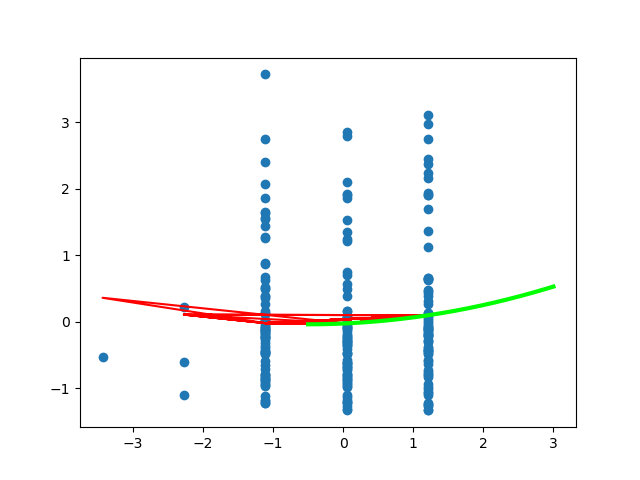

In [51]:
print(dataset1.columns[at])
plt.figure()
ax = plt.scatter(x[:,at], y)
plt.plot(x[:,at], w0 + w1*x[:,at] + w1*x[:,at]*x[:,at], color='red')
ppx = np.linspace(-0.5, 3.0, 500)
plt.plot(ppx, w0 + w1*ppx + w1*ppx*ppx, color='lime', linewidth=3)

In [114]:
class Regressor3(object):
    def __init__(self, w0, w1, w2, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.alpha = alpha

    def predict(self, x1, x2):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x1[i] + w2*x2[i]^2
        hy = []
        for i in range(len(x)):
            hy.append(self.w0 + self.w1*x1[i] + self.w2*x2[i]*x2[i])
        return hy
    
    def __update(self, hy, y, x1, x2):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        #d_w0 = 0
        d_w1 = 0
        d_w2 = 0
        for i in range(m):
            #d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x1[i]
            d_w2 = d_w2 + (hy[i] - y[i])*x2[i]*x2[i]
        
        l = 2.0
        #d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        d_w2 = (d_w2 - l*self.w2)/m
        
        #Calculem les noves w0, w1 i w2
        #self.w0 = self.w0 - self.alpha * d_w0
        self.w1 = self.w1 - self.alpha * d_w1
        self.w2 = self.w2 - self.alpha * d_w2
    
    def train(self, max_iter, epsilon, x1, x2, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x1, x2)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x1, x2)
            y_pred = self.predict(x1, x2)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 2.0
            J = (J + l*(self.w0**2 + self.w1**2 + self.w2**2))/(2*m)
            i += 1
            #print(J)
        #f[i] = w0 + w1 * x1[i] + w2*x2[i]^2
        print(J)
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x1[i]" + " + " + str(self.w2) + "*x2[i] ^2")
        return J, self.w0, self.w1

In [118]:
dataset1.columns

Index(['GenderID', 'PerfScoreID', 'Salary', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences',
       'WorkedDays', 'Age'],
      dtype='object')

In [119]:
range(len(dataset1.columns))

range(0, 10)

In [125]:
dataset1.columns[2]

'Salary'

In [127]:
for at1 in range(len(dataset1.columns)):
    if (at1!=2):
        for at2 in range(len(dataset1.columns)):
                if (at2!=2 and at1!=at2):
                    obj_reg = Regressor3(0, 0.5, 0.5, 0.1)
                    #at1 = 4
                    #at2 = 7
                    obj_reg.predict(x[:,at1], x[:,at2])
                    max_iter = 1000
                    epsilon = 0.15
                    print(dataset1.columns[at1]+" , "+dataset.columns[at2])
                    J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at1], x[:,at2], y)
                    print("---------------------------------------------------------------")
                    #model quadratic dona error mes gran

GenderID , PerfScoreID
0.49753709221874126

f[i] = 0 + 0.01938333142553407*x1[i] + -0.02755568252957353*x2[i] ^2
---------------------------------------------------------------
GenderID , EngagementSurvey
0.5002728485761427

f[i] = 0 + 0.019256352556336433*x1[i] + -0.023618986151175424*x2[i] ^2
---------------------------------------------------------------
GenderID , EmpSatisfaction
0.5008217087289499

f[i] = 0 + 0.01779427332030088*x1[i] + 0.00933420153726142*x2[i] ^2
---------------------------------------------------------------
GenderID , SpecialProjectsCount
0.36543773384050937

f[i] = 0 + 0.01406610518279068*x1[i] + 0.25109264104314793*x2[i] ^2
---------------------------------------------------------------
GenderID , DaysLateLast30


<ipython-input-114-7c730f587884>:49: RuntimeWarning: overflow encountered in double_scalars
  J = J + (y_pred[j] - y[j])**2
<ipython-input-114-7c730f587884>:51: RuntimeWarning: overflow encountered in double_scalars
  J = (J + l*(self.w0**2 + self.w1**2 + self.w2**2))/(2*m)


inf

f[i] = 0 + 5.514663984992084e+296*x1[i] + 2.849505739059927e+298*x2[i] ^2
---------------------------------------------------------------
GenderID , Absences
0.5006007479168537

f[i] = 0 + 0.0190664589734255*x1[i] + 0.019214405118461415*x2[i] ^2
---------------------------------------------------------------
GenderID , WorkedDays
0.5001791340830499

f[i] = 0 + 0.016212095104771205*x1[i] + 0.02478828159654284*x2[i] ^2
---------------------------------------------------------------
GenderID , Age
0.5007039061492106

f[i] = 0 + 0.01568647599210564*x1[i] + -0.010632252426088638*x2[i] ^2
---------------------------------------------------------------
PerfScoreID , GenderID
0.49789737265303996

f[i] = 0 + 0.08046466931803421*x1[i] + 0.0053726019452448965*x2[i] ^2
---------------------------------------------------------------
PerfScoreID , EngagementSurvey
0.4976760023717172

f[i] = 0 + 0.07658368019973742*x1[i] + -0.014401875802722027*x2[i] ^2
------------------------------------------

<ipython-input-114-7c730f587884>:26: RuntimeWarning: overflow encountered in double_scalars
  d_w2 = d_w2 + (hy[i] - y[i])*x2[i]*x2[i]
<ipython-input-114-7c730f587884>:25: RuntimeWarning: invalid value encountered in double_scalars
  d_w1 = d_w1 + (hy[i] - y[i])*x1[i]
<ipython-input-114-7c730f587884>:31: RuntimeWarning: invalid value encountered in double_scalars
  d_w2 = (d_w2 - l*self.w2)/m


nan

f[i] = 0 + nan*x1[i] + nan*x2[i] ^2
---------------------------------------------------------------
PerfScoreID , Absences
0.4976823681248374

f[i] = 0 + 0.07966549167502308*x1[i] + 0.01642440475658921*x2[i] ^2
---------------------------------------------------------------
PerfScoreID , WorkedDays
0.49718100243862406

f[i] = 0 + 0.08002414092841578*x1[i] + 0.024712265396230906*x2[i] ^2
---------------------------------------------------------------
PerfScoreID , Age
0.497594799859019

f[i] = 0 + 0.08137405907687156*x1[i] + -0.013060963183670025*x2[i] ^2
---------------------------------------------------------------
EngagementSurvey , GenderID
0.5008140177027816

f[i] = 0 + -0.02236451392187638*x1[i] + 0.004920300470906844*x2[i] ^2
---------------------------------------------------------------
EngagementSurvey , PerfScoreID
0.4972180953218059

f[i] = 0 + -0.032317227491963904*x1[i] + -0.028692645205322966*x2[i] ^2
---------------------------------------------------------------
E

0.4752426003264069

f[i] = 0 + -0.2278092303004661*x1[i] + -0.03338745381131896*x2[i] ^2
---------------------------------------------------------------
WorkedDays , EmpSatisfaction
0.47636604401557203

f[i] = 0 + -0.22454042900212404*x1[i] + 0.011561779593068408*x2[i] ^2
---------------------------------------------------------------
WorkedDays , SpecialProjectsCount
0.3587235286045472

f[i] = 0 + -0.12036832482194296*x1[i] + 0.23909342012758258*x2[i] ^2
---------------------------------------------------------------
WorkedDays , DaysLateLast30
inf

f[i] = 0 + -6.802667763750806e+295*x1[i] + 1.6573117903800727e+298*x2[i] ^2
---------------------------------------------------------------
WorkedDays , Absences
0.4760168396244119

f[i] = 0 + -0.22533175599527247*x1[i] + 0.024097622435673677*x2[i] ^2
---------------------------------------------------------------
WorkedDays , Age
0.47583707341006853

f[i] = 0 + -0.22671991477131037*x1[i] + -0.019073431266182283*x2[i] ^2
------------------

In [110]:
print(dataset1.columns[at1])
print(dataset1.columns[at2])
p_x = x[:,at1]
p_y = x[:,at2]
p_z = w0 + w1*p_x + w1*p_y*p_y

SpecialProjectsCount
Absences


In [111]:
dataset1.shape

(234, 10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
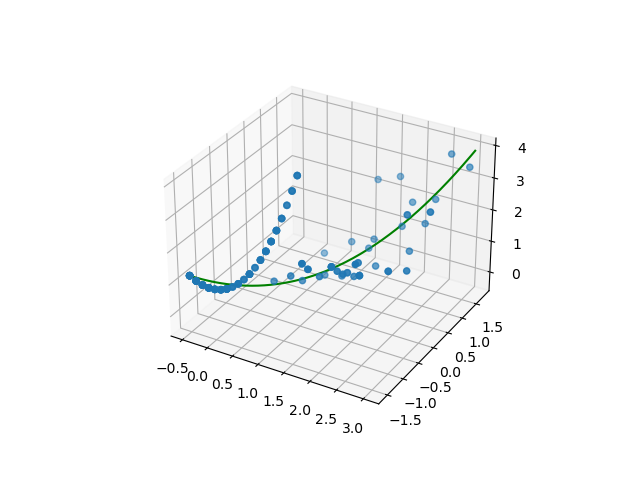

In [112]:
fig = plt.figure()

ax = plt.axes(projection ='3d')

pp_x = np.linspace(min(p_x), max(p_x), 234)
pp_y = np.linspace(min(p_y), max(p_y), 234)
pp_z = w0 + w1*pp_x + w1*pp_y*pp_y

# plotting
ax.plot3D(pp_x, pp_y, pp_z, 'green')
ax.scatter(p_x, p_y, p_z)
plt.show()